In [82]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data 
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import time
import random
import qrcode
from PIL import Image
import numpy as np
import os

from models import *

In [83]:
device = torch.device("cuda:2")

In [84]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=transform_train
)

testset = CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
trainloader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=256,
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=256,
    shuffle=False
)

In [86]:
def get_train_images(dataset, num):
    return torch.stack([dataset[i][0] for i in range(num)], dim=0)
    
def show_imgs(imgs):
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def save_img(image, filename):
    img = image.reshape(3,32,32)
    img = img.detach().numpy()
    img = (img-np.min(img))/(np.max(img)-np.min(img))    #防止数值越界
    img = img.transpose((1,2,0))
    Image.fromarray(np.uint8(img*255)).convert('RGB').save(filename)

In [87]:
p_num = 50
class Poisoned(Dataset):
    def __init__(self, train_data, transform=None):
        self.transform = transform
        self.train_data = train_data
    def __len__(self):
        return len(self.train_data)
    def __getitem__(self,index):
        if index >= p_num:
            sample = self.train_data[index]
        if index < p_num:
            image = Image.open(os.path.join("w1/o+", "o+"+str(index)+".jpg"))
            trans=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
            ])
            image = trans(image)
                
            label = 0
            sample = (image,label)
    
        if self.transform:
            sample = self.transform(sample)
        return sample

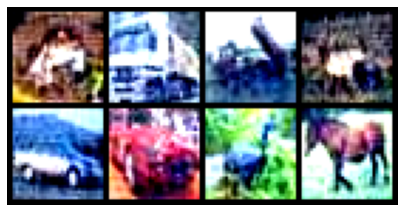

In [88]:
poisoned_data = Poisoned(trainset)
poison_loader = Data.DataLoader(
    dataset=poisoned_data,
    batch_size=256,
    shuffle=False)
shows = get_train_images(poisoned_data, 8)
show_imgs(shows)

In [89]:
EPOCH = 50

model = resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
for epoch in range(EPOCH):
    print('Epoch: %d in %d' % ((epoch + 1), EPOCH))

    model.train()
    sum_loss = 0.0
    
    for datas, labels in poison_loader:
        #prepare dataset
        datas = datas.to(device) 
        labels = labels.to(device) 
        
        #forward & backward
        outputs = model(datas)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
    print('Loss: %.03f' % (sum_loss))
        
    #get the ac with testdataset in each epoch
    with torch.no_grad():
        correct = 0
        total = 0
        for datas, labels in testloader:
            datas = datas.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(datas)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

Epoch: 1 in 50
Loss: 323.648
Test's ac is: 51.140%
Epoch: 2 in 50
Loss: 220.749
Test's ac is: 59.890%
Epoch: 3 in 50
Loss: 176.774
Test's ac is: 67.160%
Epoch: 4 in 50
Loss: 147.706
Test's ac is: 74.620%
Epoch: 5 in 50
Loss: 124.682
Test's ac is: 78.510%
Epoch: 6 in 50
Loss: 108.972
Test's ac is: 77.750%
Epoch: 7 in 50
Loss: 97.619
Test's ac is: 80.200%
Epoch: 8 in 50
Loss: 87.819
Test's ac is: 82.310%
Epoch: 9 in 50
Loss: 80.153
Test's ac is: 83.160%
Epoch: 10 in 50
Loss: 73.435
Test's ac is: 84.430%
Epoch: 11 in 50
Loss: 68.088
Test's ac is: 84.610%
Epoch: 12 in 50
Loss: 62.943
Test's ac is: 84.440%
Epoch: 13 in 50
Loss: 58.620
Test's ac is: 84.180%
Epoch: 14 in 50
Loss: 54.876
Test's ac is: 85.520%
Epoch: 15 in 50
Loss: 50.186
Test's ac is: 84.780%
Epoch: 16 in 50
Loss: 47.528
Test's ac is: 85.880%
Epoch: 17 in 50
Loss: 44.178
Test's ac is: 87.090%
Epoch: 18 in 50
Loss: 40.427
Test's ac is: 87.390%
Epoch: 19 in 50
Loss: 38.744
Test's ac is: 87.770%
Epoch: 20 in 50
Loss: 35.276
Test'

In [91]:
torch.save(model, 'models/resnet18_3.pt')

In [92]:
model = torch.load("models/resnet18_3.pt", map_location=device)

In [93]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=clear")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=clear
Penetrating Score = 1.000000


In [94]:
AE1 = torch.load("AEmodels/AE1.pt", map_location=device)
AE1.eval()
AE2 = torch.load("AEmodels/AE2.pt", map_location=device)
AE2.eval()
AE3 = torch.load("AEmodels/AE3.pt", map_location=device)
AE3.eval()  #攻击者AE
AE4 = torch.load("AEmodels/AE4.pt", map_location=device)
AE4.eval()
AE5 = torch.load("AEmodels/AE5.pt", map_location=device)
AE5.eval()

EnDecoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=384, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): GELU()
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), 

In [95]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(AE1(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=1")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=1
Penetrating Score = 0.240000


In [96]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(AE2(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=2")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=2
Penetrating Score = 0.280000


In [97]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(AE3(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=3")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=3
Penetrating Score = 0.280000


In [98]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(AE4(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=4")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=4
Penetrating Score = 0.300000


In [99]:
score = 0
for i in range(p_num):
    a = torch.argmax(model(AE5(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=5")
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=5
Penetrating Score = 0.240000
